<a href="https://colab.research.google.com/github/aSafarpoor/Traffic-Sign-Detection-DIPFinalProject-/blob/main/BlurDeblur_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# pipeline

0. read data
1. functions
    * general imformations
    * evaluation functions
    * set of functions
        * general goals
        * DIP functions

2. simple tests
    * pure wiener
    * pure sharp filter
    * combinations
        * canny + wiener
        * canny + sharp filter

3. iterative model
    * function implementation
    * improve with different image difference function



# imports

In [1]:
import cv2
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import os
from scipy.signal import convolve2d
from skimage import feature,restoration
import pickle

#0. read data

next block should run just first time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd '/content/drive'
%cd 'MyDrive'

/content/drive
/content/drive/MyDrive


In [4]:
!pwd

/content/drive/MyDrive


In [5]:
# !wget https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/TrainIJCNN2013.zip
# !unzip TrainIJCNN2013.zip
# !rm TrainIJCNN2013.zip

In [6]:
!ls | grep Train

TrainIJCNN2013


In [7]:
filenames = os.listdir('TrainIJCNN2013')

In [8]:
len(filenames)

646

In [9]:
samplesnames = filenames[0::5]
samplesnames = ['TrainIJCNN2013/'+i for i in samplesnames]
print('#:',len(samplesnames),'\nexaple name:',samplesnames[0])

#: 130 
exaple name: TrainIJCNN2013/00


TypeError: ignored

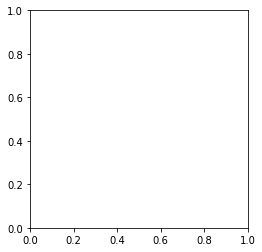

In [10]:
sampleim = cv2.imread(samplesnames[0],cv2.IMREAD_GRAYSCALE)
plt.imshow(sampleim)

In [11]:
ims = []
for name in tqdm(samplesnames[:]):
    im = cv2.imread(name,cv2.IMREAD_GRAYSCALE)
    # 
    try:
        if im.shape != (800, 1360):
            print(im.shape,type(im))
        else:
            ims.append(np.copy(im))
    except:
        pass
ims = np.array(ims)
print('\n-----------------------------------------\nshape:',ims.shape,
      '\n------------------------------------------\n# samples:',ims.shape[0],'\nsample shape:',ims.shape[1:])

100%|██████████| 130/130 [00:03<00:00, 39.57it/s]


-----------------------------------------
shape: (120, 800, 1360) 
------------------------------------------
# samples: 120 
sample shape: (800, 1360)


#1. functions

## general informations:

In [12]:
info = {"imsshape": ims.shape,
        "lenims"  : ims.shape[0],
        "imshape" : ims.shape[1:],
        "imsize"  : ims.shape[1]*ims.shape[2]}
info

{'imsshape': (120, 800, 1360),
 'lenims': 120,
 'imshape': (800, 1360),
 'imsize': 1088000}

## evaluation functions


lets note:

for similarity between (img1,img2):
* compare images
    * simple mode: **compare_image**
    * **compare_boolean_image**
        * usage example: **edge_similarity**

image attributes:
* **varofimage**
* **varoflaplace**

In [13]:
def varofimage(img):
    return img.var()

In [14]:
def varoflaplace(img):
    return cv2.Laplacian(img, cv2.CV_64F).var()

In [15]:
def edge_similarity(img1,img2,sigma=3):
    edge1 = feature.canny(img1,sigma=sigma)
    edge2 = feature.canny(img2,sigma=sigma)
    return compare_boolean_image(edge1,edge2,imsize=1088000)

## general goal *functions*

In [16]:
def imshower(img):
    fig = plt.imshow(img);
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.show()

In [17]:
def normalizer(img,max_=1):
    mi = img.min()
    img -= mi
    ma = img.max()
    img = img / ma
    img = img * max_
    return img

In [18]:
def compare_image(img1,img2,imsize=1088000):
    return round(100*np.abs(img1-img2).sum()/imsize,2)

In [19]:
def compare_boolean_image(img1,img2,imsize=1088000):
    return round(100*(img1==img2).sum()/imsize,2)

##DIP specific functions

1. wiener
2. canny
3. ...

In [20]:
def wiener(img,kernel,if_unsupervised=True,supervised_regullizer_parameter=1100):
    if if_unsupervised:
        deconvolved, _ = restoration.unsupervised_wiener(img, kernel)
    else:
        deconvolved = restoration.wiener(img, kernel, supervised_regullizer_parameter)
    return deconvolved

below functions are just for remembrance, we will use inner part of them directly to recieve lower time consuming

In [21]:
def canny(img,sigma=3):
    feature.canny(img,sigma=sigma)

In [22]:
def img_sharpenning(img,kernel=np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1]])):
    return convolve2d(img,kernel,'same')

In [23]:
def blurrer(img,kernel=np.array([[1,1,1],[1,1,1],[1,1,1]])/9):
    return convolve2d(img,kernel,'same')

# 2. simple tests

In [ ]:
info

{'imshape': (800, 1360),
 'imsize': 1088000,
 'imsshape': (116, 800, 1360),
 'lenims': 116}

pure wiener

In [ ]:
wlogs = {}

wlogs['original_var'] = np.zeros(info['lenims'])
wlogs['original_lap_var'] = np.zeros(info['lenims'])
wlogs['blur_var'] = np.zeros(info['lenims'])
wlogs['blur_lap_var'] = np.zeros(info['lenims'])
wlogs['wiener_var'] = np.zeros(info['lenims'])
wlogs['wiener_lap_var'] = np.zeros(info['lenims'])
wlogs['blur&original similarity'] = np.zeros(info['lenims'])
wlogs['wiener&original similarity'] = np.zeros(info['lenims'])
wlogs['blur&original edge similarity'] = np.zeros(info['lenims'])
wlogs['wiener&original edge similarity'] = np.zeros(info['lenims'])

wiener_ims = []

for c, im_c in tqdm(enumerate(ims)):
    #original := im
    im = np.copy(im_c)
    im -= im.min()
    im = im/im.max()

    ksize = 3 #best kernell size that we found based on tests
    kernel = np.ones((ksize,ksize))

    #blur := bsample
    blur_kernel = np.ones((3,3))
    bsample = convolve2d(im,blur_kernel,'same') 
    bsample -=  bsample.min()
    bsample =  bsample/bsample.max()

    #wiener : wsample
    wsample = wiener(bsample,kernel)
    wsample -=  wsample.min()
    wsample =  wsample/wsample.max()
    wiener_ims.append(wsample)

    wlogs['original_var'][c] = im.var()
    wlogs['original_lap_var'][c] = cv2.Laplacian(im, cv2.CV_64F).var()
    
    wlogs['blur_var'][c] = bsample.var()
    wlogs['blur_lap_var'][c] = cv2.Laplacian(bsample, cv2.CV_64F).var()
    
    wlogs['wiener_var'][c] = wsample.var()
    wlogs['wiener_lap_var'][c] = cv2.Laplacian(wsample, cv2.CV_64F).var()

    wlogs['blur&original similarity'][c] = compare_image(im,bsample)
    wlogs['wiener&original similarity'][c] = compare_image(im,wsample)
    edge_of_im = feature.canny(im)
    wlogs['blur&original edge similarity'][c] = compare_boolean_image(edge_of_im,feature.canny(wsample))
    wlogs['wiener&original edge similarity'][c] = compare_boolean_image(edge_of_im,feature.canny(bsample))

    # imshower(wsample)
    # imshower(feature.canny(wsample))
    # imshower(feature.canny(im))

116it [10:18,  5.33s/it]


In [ ]:
with open('wlogs.pickle', 'wb') as handle:
    pickle.dump(wlogs, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('wlogs.pickle', 'rb') as handle:
    # wlogs = pickle.load(handle)

In [ ]:
with open('wiener_ims.pickle', 'wb') as handle:
    pickle.dump(wiener_ims, handle, protocol=pickle.HIGHEST_PROTOCOL)

# with open('wiener_ims.pickle', 'rb') as handle:
    # wiener_ims = pickle.load(handle)

In [36]:
# with open('wiener_ims.pickle', 'rb') as handle:
#     wiener_ims = pickle.load(handle)

In [ ]:
w_avg = {}

w_avg['blur_var']                        = round(np.average(wlogs['blur_var']),3)
w_avg['wiener_var']                      = round(np.average(wlogs['wiener_var']),3) 
w_avg['blur_lap_var']                    = round(np.average(wlogs['blur_lap_var']),3) 
w_avg['original_var']                    = round(np.average(wlogs['original_var']),3) 
w_avg['wiener_lap_var']                  = round(np.average(wlogs['wiener_lap_var']),3) 
w_avg['original_lap_var']                = round(np.average(wlogs['original_lap_var']),3) 
w_avg['blur&original similarity']        = round(np.average(wlogs['blur&original similarity']),3) 
w_avg['wiener&original similarity']      = round(np.average(wlogs['wiener&original similarity']),3) 
w_avg['blur&original edge similarity']   = round(np.average(wlogs['blur&original edge similarity']),3) 
w_avg['wiener&original edge similarity'] = round(np.average(wlogs['wiener&original edge similarity']),3) 

In [ ]:
w_avg

{'blur&original edge similarity': 96.678,
 'blur&original similarity': 1.447,
 'blur_lap_var': 0.002,
 'blur_var': 0.13,
 'original_lap_var': 0.014,
 'original_var': 0.131,
 'wiener&original edge similarity': 96.447,
 'wiener&original similarity': 17.015,
 'wiener_lap_var': 0.005,
 'wiener_var': 0.032}

pure sharp filter

In [ ]:
slogs = {}

slogs['sharp_var'] = np.zeros(info['lenims'])
slogs['sharp_lap_var'] = np.zeros(info['lenims'])
slogs['sharp&original similarity'] = np.zeros(info['lenims'])
slogs['sharp&original edge similarity'] = np.zeros(info['lenims'])


for c, im_c in tqdm(enumerate(ims)):
    im = np.copy(im_c)
    im -= im.min()
    im = im/im.max()

    ksize = 3 #best kernell size that we found based on tests
    kernel = np.ones((ksize,ksize))
    #blur := bsample
    blur_kernel = np.ones((3,3))
    bsample = convolve2d(im,blur_kernel,'same') 
    bsample -=  bsample.min()
    bsample =  bsample/bsample.max()

    
    #wiener : wsample
    shsample = img_sharpenning(bsample)
    shsample -= shsample.min()
    shsample = shsample/shsample.max()

    slogs['sharp_var'][c] = shsample.var()
    slogs['sharp_lap_var'][c] = cv2.Laplacian(shsample, cv2.CV_64F).var()
    slogs['sharp&original similarity'][c] = compare_image(im,shsample)

    edge_of_im = feature.canny(im)
    slogs['sharp&original edge similarity'][c] = compare_boolean_image(edge_of_im,feature.canny(shsample))

116it [02:02,  1.06s/it]


In [ ]:
with open('slogs.pickle', 'wb') as handle:
    pickle.dump(slogs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
s_avg = {}

s_avg['sharp_var']                        = round(np.average(slogs['sharp_var']),3)
s_avg['sharp_lap_var']                    = round(np.average(slogs['sharp_lap_var']),3) 
s_avg['sharp&original similarity']        = round(np.average(slogs['sharp&original similarity']),3) 
s_avg['sharp&original edge similarity']        = round(np.average(slogs['sharp&original edge similarity']),3) 

In [ ]:
s_avg

{'sharp&original edge similarity': 95.925,
 'sharp&original similarity': 25.173,
 'sharp_lap_var': 0.003,
 'sharp_var': 0.008}

combinations of canny & wiener

In [ ]:
cwlogs = {}

cwlogs['cw_var'] = np.zeros(info['lenims'])
cwlogs['cw_lap_var'] = np.zeros(info['lenims'])
cwlogs['cw&original similarity'] = np.zeros(info['lenims'])
cwlogs['cwin&original edge similarity'] = np.zeros(info['lenims'])


for c, im_c in tqdm(enumerate(ims)):
    im = np.copy(im_c)
    im -= im.min()
    im = im/im.max()

    wim = np.copy(wiener_ims[c])
    wim -= im.min()
    wim = im/im.max()

    ksize = 3 #best kernell size that we found based on tests
    kernel = np.ones((ksize,ksize))
    #blur := bsample
    blur_kernel = np.ones((3,3))
    bsample = convolve2d(im,blur_kernel,'same') 
    bsample -=  bsample.min()
    bsample =  bsample/bsample.max()

    cwim = wim + feature.canny(bsample,sigma=3)
    cwim[cwim>1]=1
    cwim -= cwim.min()
    cwim = cwim/cwim.max()

    cwlogs['cw_var'][c] = cwim.var()
    cwlogs['cw_lap_var'][c] = cv2.Laplacian(cwim, cv2.CV_64F).var()
    cwlogs['cw&original similarity'][c] = compare_image(im,cwim)

    edge_of_im = feature.canny(im)
    cwlogs['cwin&original edge similarity'][c] = compare_boolean_image(edge_of_im,feature.canny(cwim))

116it [02:21,  1.22s/it]


In [ ]:
cw_avg = {}

cw_avg['cw_var']                        = round(np.average(cwlogs['cw_var']),3)
cw_avg['cw_lap_var']                    = round(np.average(cwlogs['cw_lap_var']),3) 
cw_avg['cw&original similarity']        = round(np.average(cwlogs['cw&original similarity']),3) 
cw_avg['cwin&original edge similarity'] = round(np.average(cwlogs['cwin&original edge similarity']),3)

cw_avg

{'cw&original similarity': 1.368,
 'cw_lap_var': 0.072,
 'cw_var': 0.137,
 'cwin&original edge similarity': 95.429}

In [ ]:

cw2logs = {}

cw2logs['cw_var'] = np.zeros(info['lenims'])
cw2logs['cw_lap_var'] = np.zeros(info['lenims'])
cw2logs['cw&original similarity'] = np.zeros(info['lenims'])
cw2logs['cwin&original edge similarity'] = np.zeros(info['lenims'])


for c, im_c in tqdm(enumerate(ims)):
    im = np.copy(im_c)
    im -= im.min()
    im = im/im.max()

    wim = np.copy(wiener_ims[c])
    wim -= im.min()
    wim = im/im.max()

    ksize = 3 #best kernell size that we found based on tests
    kernel = np.ones((ksize,ksize))
    #blur := bsample
    blur_kernel = np.ones((3,3))
    bsample = convolve2d(im,blur_kernel,'same') 
    bsample -=  bsample.min()
    bsample =  bsample/bsample.max()

    cwim = wim + 0.5*feature.canny(bsample,sigma=3)
    cwim[cwim>1]=1
    cwim -= cwim.min()
    cwim = cwim/cwim.max()

    cw2logs['cw_var'][c] = cwim.var()
    cw2logs['cw_lap_var'][c] = cv2.Laplacian(cwim, cv2.CV_64F).var()
    cw2logs['cw&original similarity'][c] = compare_image(im,cwim)

    edge_of_im = feature.canny(im)
    cw2logs['cwin&original edge similarity'][c] = compare_boolean_image(edge_of_im,feature.canny(cwim))

116it [02:30,  1.30s/it]


In [ ]:
cw2_avg = {}

cw2_avg['cw_var']                        = round(np.average(cw2logs['cw_var']),3)
cw2_avg['cw_lap_var']                    = round(np.average(cw2logs['cw_lap_var']),3) 
cw2_avg['cw&original similarity']        = round(np.average(cw2logs['cw&original similarity']),3) 
cw2_avg['cwin&original edge similarity'] = round(np.average(cw2logs['cwin&original edge similarity']),3)

cw2_avg

{'cw&original similarity': 1.075,
 'cw_lap_var': 0.045,
 'cw_var': 0.134,
 'cwin&original edge similarity': 95.734}

In [ ]:
with open('cwlogs.pickle', 'wb') as handle:
    pickle.dump(cwlogs, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('cw2logs.pickle', 'wb') as handle:
    pickle.dump(cw2logs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:
with open('cw2logs.pickle', 'rb') as handle:
    cw2logs = pickle.load(handle)

In [25]:
cw2logs.keys()

dict_keys(['cw_var', 'cw_lap_var', 'cw&original similarity', 'cwin&original edge similarity'])

In [26]:
cw2_avg = {}

cw2_avg['cw_var']                        = round(np.average(cw2logs['cw_var']),3)
cw2_avg['cw_lap_var']                    = round(np.average(cw2logs['cw_lap_var']),3) 
cw2_avg['cw&original similarity']        = round(np.average(cw2logs['cw&original similarity']),3)
cw2_avg['cwin&original edge similarity']        = round(np.average(cw2logs['cwin&original edge similarity']),3) 


cw2_avg

{'cw_var': 0.134,
 'cw_lap_var': 0.045,
 'cw&original similarity': 1.075,
 'cwin&original edge similarity': 95.734}

#3. iterative model

In [27]:
def loss1(current_image,kernel,blurred_image):
    temp = convolve2d(current_image, kernel,"same") - blurred_image
    return 0.5 * (temp**2).sum()

In [28]:
def gradient(current_image,kernel,blurred_image):
    temp = convolve2d(current_image, kernel,'same')
    return convolve2d(temp - blurred_image, kernel.T,'same')

In [ ]:
im = ims[0].copy()
kernel = np.ones((3,3))/9
blurred_image = blurrer(im)    
im = im/im.max()
blurred_image = blurred_image/blurred_image.max()
g = gradient(im,blurred_image,kernel)\
plt.imshow(g)

In [29]:
def iterator(blurred_image,kernel,max_iter=500,least_loss=10,current_image=""):
    learning_rate = 0.01
    
    if current_image == "":
        current_image = np.copy(blurred_image)

    converge_flag = True
    iter = 1
    loss_list = []
    while(iter<=max_iter and converge_flag):
        if iter %50 == 0:
            print("interation number = ",iter)
            print(loss)

        iter += 1
        current_image -= learning_rate*gradient(current_image,kernel,blurred_image)
        
        loss = round(loss1(current_image,kernel,blurred_image),2)
        loss_list.append(loss)
        
        if loss<least_loss:
            converge_flag = False
    print(iter-1)
    return loss_list, current_image

In [30]:
im = ims[0].copy()
kernel = np.ones((3,3))/9
blurred_image = blurrer(im)    
im = im/im.max()
blurred_image = blurred_image/blurred_image.max()


In [31]:
loss_list, current_image = iterator(blurred_image,kernel,max_iter=500,least_loss=1)

interation number =  50
147.06
interation number =  100
106.08
interation number =  150
80.17
interation number =  200
63.01
interation number =  250
51.15
interation number =  300
42.62
interation number =  350
36.28
interation number =  400
31.41
interation number =  450
27.59
interation number =  500
24.51
500


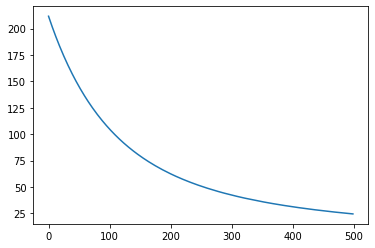

In [32]:
plt.plot(loss_list)

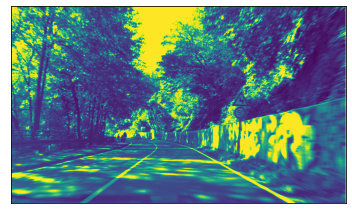

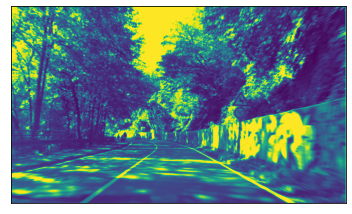

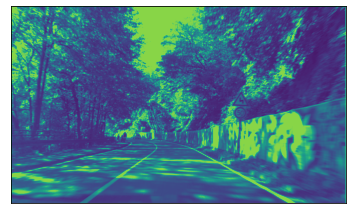

In [33]:
imshower(im)
imshower(blurred_image)
imshower(current_image)

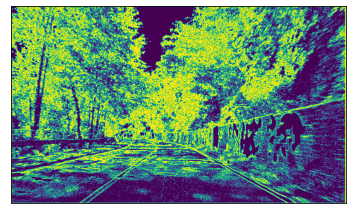

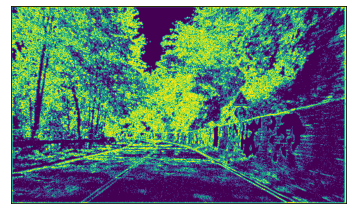

In [34]:
# imshower(im)
temp = abs(blurred_image-im)
temp[temp>0.01] = 1
temp[temp<0.5] = 0
imshower(temp)
temp = abs(current_image-im)
temp[temp>0.01] = 1
temp[temp<0.5] = 0
imshower(temp)

In [37]:
cwlogs = {}

cwlogs['cw_var'] = np.zeros(info['lenims'])
cwlogs['cw_lap_var'] = np.zeros(info['lenims'])
cwlogs['cw&original similarity'] = np.zeros(info['lenims'])
cwlogs['cwin&original edge similarity'] = np.zeros(info['lenims'])


for c, im_c in tqdm(enumerate(ims[:1])):
    im = np.copy(im_c)
    im -= im.min()
    im = im/im.max()

    wim = np.copy(wiener_ims[c])
    wim -= im.min()
    wim = im/im.max()

    ksize = 3 #best kernell size that we found based on tests
    kernel = np.ones((ksize,ksize))
    #blur := bsample
    blur_kernel = np.ones((3,3))
    bsample = convolve2d(im,blur_kernel,'same') 
    bsample -=  bsample.min()
    bsample =  bsample/bsample.max()

    cwim = wim + feature.canny(bsample,sigma=3)
    cwim[cwim>1]=1
    cwim -= cwim.min()
    cwim = cwim/cwim.max()

    l1,current_image1 = iterator(np.copy(bsample),kernel,max_iter=100,least_loss=1)
    l2,current_image_cwim = iterator(np.copy(bsample),kernel,max_iter=100,least_loss=1,current_image=cwim)
    
    print(l1[-1])
    print(l2[-1])


0it [00:00, ?it/s]

interation number =  50
3.39
95


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


interation number =  50
763.9


1it [00:34, 34.93s/it]

interation number =  100
291.24
100
0.98
287.27


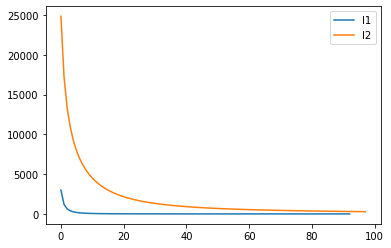

In [38]:
plt.plot(l1[2:], label = 'l1')
plt.plot(l2[2:], label = 'l2')
plt.legend()
plt.show()

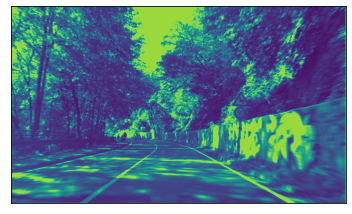

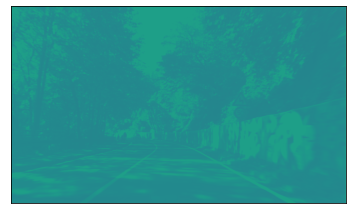

In [39]:
imshower(current_image1)
imshower(current_image_cwim)

#4. eddited iterative model

**edge based model**

In [40]:
def iterator2(blurred_image,edge_image,kernel,max_iter=500,least_loss=10):
    learning_rate = 0.01

    current_image = np.copy(blurred_image)

    converge_flag = True
    iter = 1
    loss_list = []
    edge_active = True
    while(iter<=max_iter and converge_flag):
        if iter %50 == 0:
            print("interation number = ",iter)
            print(loss)

        iter += 1
        if edge_active:
            current_image += 0.004*edge_image
        
        current_image -= learning_rate*gradient(current_image,kernel,blurred_image)
        
        lossedge = round(loss1(current_image+ 0.004*edge_image,kernel,blurred_image),2)
        loss = round(loss1(current_image,kernel,blurred_image),2)
        
        edge_active = True
        if loss<lossedge:
            edge_active = False
        else:
            loss = lossedge

        loss_list.append(loss)
        
        if loss<least_loss:
            converge_flag = False

    print(iter-1)
    return loss_list, current_image

In [41]:
im = ims[0].copy()
kernel = np.ones((3,3))/9
blurred_image = blurrer(im)    
im = im/im.max()
blurred_image = blurred_image/blurred_image.max()


In [42]:
edge = feature.canny(blurred_image,sigma=3)
loss_list, current_image = iterator2(blurred_image,edge_image=edge,kernel=kernel,max_iter=600,least_loss=1)

interation number =  50
147.44
interation number =  100
106.38
interation number =  150
80.41
interation number =  200
63.21
interation number =  250
51.31
interation number =  300
42.75
interation number =  350
36.38
interation number =  400
31.5
interation number =  450
27.66
interation number =  500
24.58
interation number =  550
22.04
interation number =  600
19.93
600


In [43]:
edge = feature.canny(blurred_image)
loss_list2, current_image2 = iterator2(blurred_image,edge,kernel,max_iter=600,least_loss=1)

interation number =  50
146.97
interation number =  100
106.24
interation number =  150
80.43
interation number =  200
63.3
interation number =  250
51.43
interation number =  300
42.89
interation number =  350
36.52
interation number =  400
31.64
interation number =  450
27.79
interation number =  500
24.69
interation number =  550
22.15
interation number =  600
20.03
600


In [44]:
loss_list3, current_image3 = iterator(blurred_image,kernel=kernel,max_iter=600,least_loss=1)

interation number =  50
147.06
interation number =  100
106.08
interation number =  150
80.17
interation number =  200
63.01
interation number =  250
51.15
interation number =  300
42.62
interation number =  350
36.28
interation number =  400
31.41
interation number =  450
27.59
interation number =  500
24.51
interation number =  550
21.98
interation number =  600
19.88
600


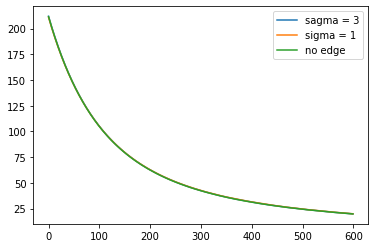

In [45]:
plt.plot(loss_list,label="sagma = 3")
plt.plot(loss_list2,label="sigma = 1")
plt.plot(loss_list3,label="no edge")
plt.legend()
plt.show()

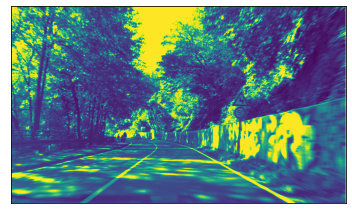

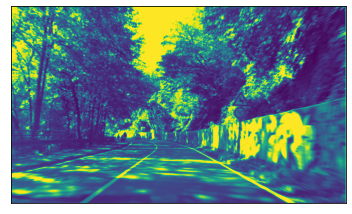

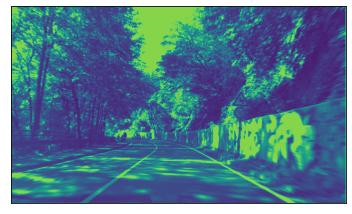

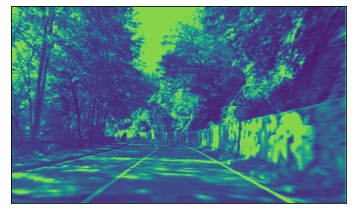

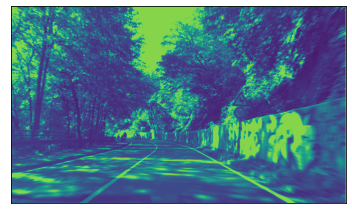

In [46]:
imshower(im)
imshower(blurred_image)
imshower(current_image)
imshower(current_image2)
imshower(current_image3)


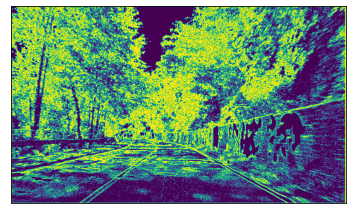

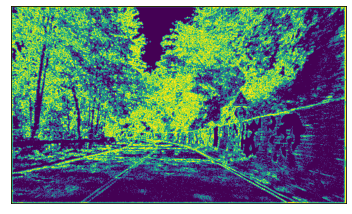

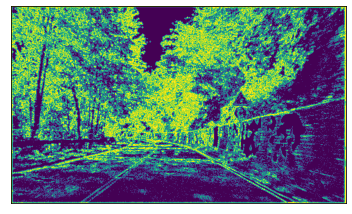

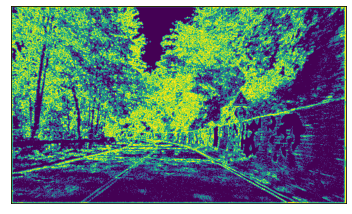

In [47]:
# imshower(im)
temp = abs(blurred_image-im)
temp[temp>0.01] = 1
temp[temp<0.5] = 0
imshower(temp)
temp = abs(current_image-im)
temp[temp>0.01] = 1
temp[temp<0.5] = 0
imshower(temp)
temp = abs(current_image2-im)
temp[temp>0.01] = 1
temp[temp<0.5] = 0
imshower(temp)
temp = abs(current_image3-im)
temp[temp>0.01] = 1
temp[temp<0.5] = 0
imshower(temp)

In [49]:
for c, im_c in tqdm(enumerate(ims[:1])):
    im = np.copy(im_c)
    im -= im.min()
    im = im/im.max()

    wim = np.copy(wiener_ims[c])
    wim -= im.min()
    wim = im/im.max()

    ksize = 3 #best kernell size that we found based on tests
    kernel = np.ones((ksize,ksize))
    #blur := bsample
    blur_kernel = np.ones((3,3))
    bsample = convolve2d(im,blur_kernel,'same') 
    bsample -=  bsample.min()
    bsample =  bsample/bsample.max()

    

    l1,current_image1 = iterator(np.copy(bsample),kernel,max_iter=100,least_loss=10)
    l2,current_image_cwim = iterator2(np.copy(bsample),edge,kernel,max_iter=100,least_loss=1)
    
    print(l1[-1])
    print(l2[-1])


0it [00:00, ?it/s]

29
interation number =  50
3.52


1it [00:25, 25.74s/it]

98
9.99
0.98


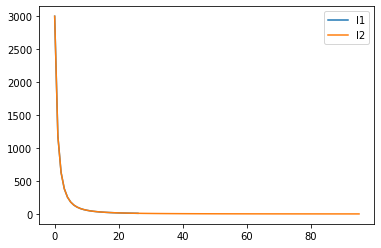

In [50]:
plt.plot(l1[2:], label = 'l1')
plt.plot(l2[2:], label = 'l2')
plt.legend()
plt.show()

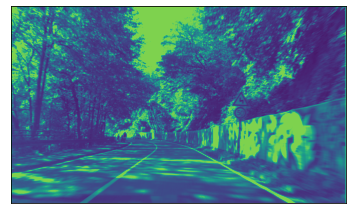

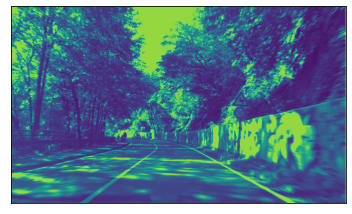

In [51]:
imshower(current_image1)
imshower(current_image_cwim)